# ItalianSignNet study

### Importing Required Libraries

In [1]:
import numpy as np
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras as keras
from PIL import Image
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import accuracy_score
import albumentations as A
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import layers, models
from tensorflow.keras.utils import Sequence
from tensorflow.keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
import pickle
import glob
from sklearn.metrics import classification_report

import logging
logging.getLogger('lime').setLevel(logging.ERROR)


2025-06-14 14:55:50.411180: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-06-14 14:55:50.464839: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-06-14 14:55:50.464893: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-06-14 14:55:50.467840: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-06-14 14:55:50.487295: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-06-14 14:55:50.487963: I tensorflow/core/platform/cpu_feature_guard.cc:1

In [2]:
import mlflow

def is_running_on_databricks():
    return os.environ.get("DATABRICKS_RUNTIME_VERSION") is not None

def configure_mlflow():
    if is_running_on_databricks():
        mlflow.set_tracking_uri("databricks")
        print("MLflow on Databricks")
    else:
        mlflow.set_tracking_uri("http://mlflow:5000")
        print("Local MLFlow")
        
configure_mlflow()
mlflow.set_experiment("traffic-signs-classification")


Local MLFlow


<Experiment: artifact_location='/mlflow/mlflow_data/mlruns/1', creation_time=1749295058439, experiment_id='1', last_update_time=1749295058439, lifecycle_stage='active', name='traffic-signs-classification', tags={}>

### Boiterplate

In [3]:
DATASET_NAME = 'dataset_20250613_125529_eps_100'
DATASET_BASE_PATH = '/kaggle/input' if os.path.isdir('/kaggle/working') else '/workspace/src/dataset/artifacts'
DATA_DIR = f'{DATASET_BASE_PATH}/{DATASET_NAME}'
TRAIN_PATH = f'{DATA_DIR}/train'
TEST_PATH = f'{DATA_DIR}/test'
VAL_PATH = f'{DATA_DIR}/validation'

IMG_HEIGHT = 64
IMG_WIDTH = 64
CHANNELS = 3
BATCH_SIZE = 32
LR = 0.001
EPOCHS = 30

# kaggle or docker kernel
WORSPACE_PATH = '/kaggle/working' if os.path.isdir('/kaggle/working') else '/workspace/src/models/notebook-workspace'
FORCE_TRAIN_MODELS=False

SEED = 42
np.random.seed(SEED)

CLASSES = { 
    0:'Speed limit (20km/h)',
    1:'Speed limit (30km/h)', 
    2:'Speed limit (50km/h)', 
    3:'Speed limit (60km/h)', 
    4:'Speed limit (70km/h)', 
    5:'Speed limit (80km/h)', 
    6:'End of speed limit (80km/h)', 
    7:'Speed limit (100km/h)', 
    8:'Speed limit (120km/h)', 
    9:'No passing', 
    10:'No passing veh over 3.5 tons', 
    11:'Right-of-way at intersection', 
    12:'Priority road', 
    13:'Yield', 
    14:'Stop', 
    15:'No vehicles', 
    16:'Veh > 3.5 tons prohibited', 
    17:'No entry', 
    18:'General caution', 
    19:'Dangerous curve left', 
    20:'Dangerous curve right', 
    21:'Double curve', 
    22:'Bumpy road', 
    23:'Slippery road', 
    24:'Road narrows on the right', 
    25:'Road work', 
    26:'Traffic signals', 
    27:'Pedestrians', 
    28:'Children crossing', 
    29:'Bicycles crossing', 
    30:'Beware of ice/snow',
    31:'Wild animals crossing', 
    32:'End speed + passing limits', 
    33:'Turn right ahead', 
    34:'Turn left ahead', 
    35:'Ahead only', 
    36:'Go straight or right', 
    37:'Go straight or left', 
    38:'Keep right', 
    39:'Keep left', 
    40:'Roundabout mandatory', 
    41:'End of no passing', 
    42:'End no passing veh > 3.5 tons' 
}

### Visualizing The Dataset

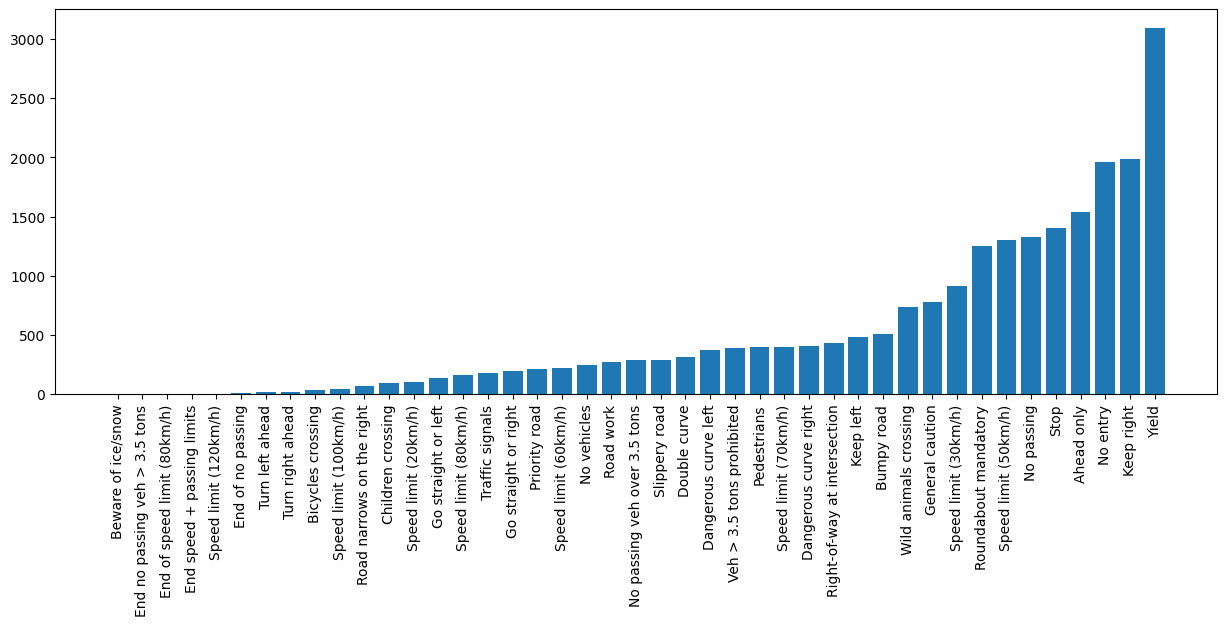

In [4]:
folders = os.listdir(TRAIN_PATH)

train_number = []
class_num = []

for folder in folders:
    train_files = os.listdir(TRAIN_PATH + '/' + folder)
    train_number.append(len(train_files))
    class_num.append(CLASSES[int(folder)])
    
# Sorting the dataset on the basis of number of images in each class
zipped_lists = zip(train_number, class_num)
sorted_pairs = sorted(zipped_lists)
tuples = zip(*sorted_pairs)
train_number, class_num = [ list(tuple) for tuple in  tuples]

# Plotting the number of images in each class
plt.figure(figsize=(15,5))  
plt.bar(class_num, train_number)
plt.xticks(class_num, rotation='vertical')
plt.show()

### Albumentation visualitation

/tmp/ipykernel_9/1991181784.py:41: UserWarning: Argument(s) 'fog_coef' are not valid for transform RandomFog
  {"name": "Fog", "transform": A.RandomFog(p=1, fog_coef=0.8)},


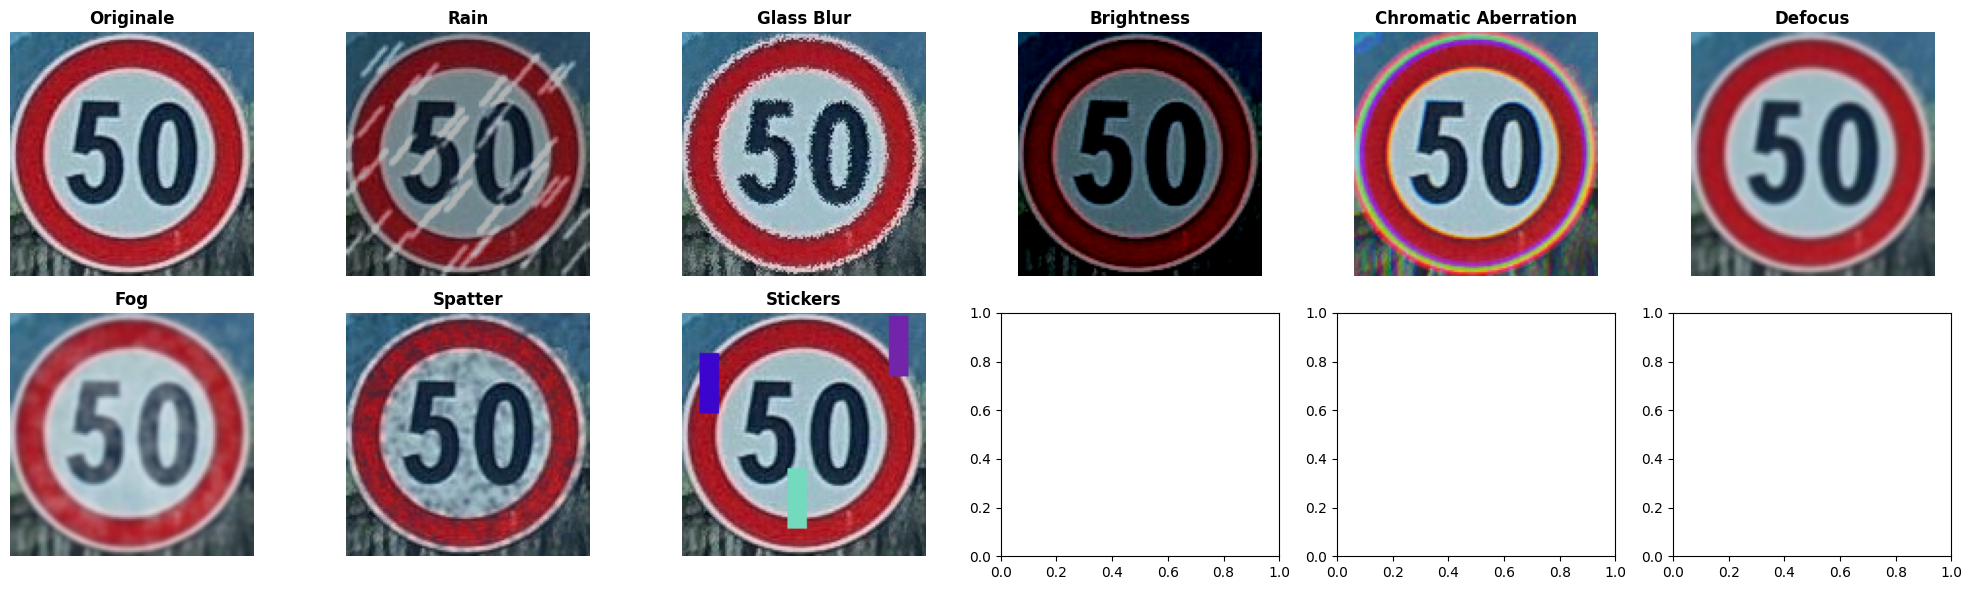

In [5]:
def show_albumentations_example(path):
    image_albumentations_example = cv2.imread(path)
    image_albumentations_example = cv2.cvtColor(image_albumentations_example, cv2.COLOR_BGR2RGB)

    transformations = [
        {"name": "Rain", "transform": A.RandomRain(
            slant_range=[-15, 15],
            drop_width=1,
            drop_color=[500, 500, 500],
            blur_value=3,
            brightness_coefficient=0.7,
            rain_type="default",
            p=1
        )},
        {"name": "Glass Blur", "transform": A.GlassBlur(
            sigma=0.2,
            max_delta=1,
            iterations=1,
            mode="fast",
            p=1
        )},
        {"name": "Brightness", "transform": A.RandomBrightnessContrast(
            brightness_limit=[-0.5, 0.2],
            contrast_limit=[-0.2, 0.2],
            brightness_by_max=True,
            ensure_safe_range=False,
            p=1
        )},
        {"name": "Chromatic Aberration", "transform": A.ChromaticAberration(
            primary_distortion_limit=[-0.5, 0.5],
            secondary_distortion_limit=[-0.3, 0.3],
            mode="random",
            interpolation=cv2.INTER_LINEAR,
            p=1
        )},
        {"name": "Defocus", "transform": A.Defocus(
            radius=[1, 5],
            alias_blur=[0.1, 0.5],
            p=1
        )},
        {"name": "Fog", "transform": A.RandomFog(p=1, fog_coef=0.8)},
        {"name": "Spatter", "transform": A.Spatter(
            mean=[0.25, 0.25],
            std=[0.2, 0.2],
            gauss_sigma=[1, 2],
            cutout_threshold=[0.58, 0.68],
            intensity=[0.6, 0.8],
            mode="mud",
            p=1
        )},
        {"name": "Stickers", "transform": A.GridDropout(
            holes_number_xy=[1, 3],
            ratio=0.25,
            random_offset=True,
            fill="random_uniform",
            p=1
        )}
    ]
    
    # Visualizzazione
    fig, axes = plt.subplots(2, 6, figsize=(20, 6))
    
    # Mostra immagine originale
    axes[0, 0].imshow(image_albumentations_example)
    axes[0, 0].set_title("Originale", fontsize=12, fontweight='bold')
    axes[0, 0].axis("off")
    
    # Applica trasformazioni
    for i, t in enumerate(transformations):
        row = (i + 1) // 6
        col = (i + 1) % 6
        transformed_image = t["transform"](image=image_albumentations_example)['image']
        axes[row, col].imshow(transformed_image)
        axes[row, col].set_title(t["name"], fontsize=12, fontweight='bold')
        axes[row, col].axis("off")
    
    plt.tight_layout()
    plt.show()


show_albumentations_example(f"{TEST_PATH}/02/138649562181816_339.jpg")

## Collecting the Training Data

In [7]:
def process_image(image_path: str):
    try:
        image = cv2.imread(image_path)
        if image is None:
            raise ValueError("Image is None")
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, (IMG_WIDTH, IMG_HEIGHT))
        return image
    except Exception as e:
        print(f"Error in {image_path}: {e}")
        return None


def read_train_dataset_images():
    image_data = []
    image_labels = []
    for i in range(len(CLASSES)):
        path = os.path.join(TRAIN_PATH, f"{i:02d}")
    
        if not os.path.isdir(path):
            print(f'not exist {path}')
            continue

        images = os.listdir(path)
        for img in images:
            processed = process_image(os.path.join(path, img))
            if processed is not None:
                image_data.append(processed)
                image_labels.append(f"{i:02d}")
            else:
                print(f"Skipped: {img} in {path}")
    
    image_data = np.array(image_data)
    image_labels = np.array(image_labels)
    return image_data, image_labels

image_data, image_labels = read_train_dataset_images()
print(image_data.shape, image_labels.shape)

(22620, 64, 64, 3) (22620,)


### Shuffling the training data

In [8]:
def shuffle_training_data():
    shuffle_indexes = np.arange(image_data.shape[0])
    np.random.shuffle(shuffle_indexes)
    return image_data[shuffle_indexes], image_labels[shuffle_indexes]

image_data, image_labels = shuffle_training_data()

## Collecting validation set

In [9]:
X_train = image_data.astype('float32') / 255.

val_data = []
val_labels = []
for label_name in os.listdir(VAL_PATH):
    label_dir = os.path.join(VAL_PATH, label_name)
    if not os.path.isdir(label_dir):
        continue
    for img_file in os.listdir(label_dir):
        img_path = os.path.join(label_dir, img_file)
        processed = process_image(img_path)
        if processed is not None:
            val_data.append(processed)
            val_labels.append(int(label_name))
        else:
            print(f"Skipped invalid image: {img_path}")

X_val = np.array(val_data, dtype='float32') / 255.
val_labels = np.array(val_labels) 

print("X_train.shape", X_train.shape)
print("X_val.shape",   X_val.shape)

X_train.shape (22620, 64, 64, 3)
X_val.shape (4841, 64, 64, 3)


#### One hot encoding the labels

In [10]:
y_train = keras.utils.to_categorical(image_labels, len(CLASSES))
y_val = keras.utils.to_categorical(val_labels, len(CLASSES))
print("y_train.shape", y_train.shape)
print("y_val.shape",   y_val.shape)

y_train.shape (22620, 43)
y_val.shape (4841, 43)


## Making models

In [6]:
model = keras.models.Sequential([ 
    keras.layers.Conv2D(filters=16, kernel_size=(3,3), activation='relu', input_shape=(IMG_HEIGHT,IMG_WIDTH,CHANNELS)),
    keras.layers.Conv2D(filters=32, kernel_size=(3,3), activation='relu'),
    keras.layers.MaxPool2D(pool_size=(2, 2)),
    keras.layers.BatchNormalization(axis=-1),
    
    keras.layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu'),
    keras.layers.Conv2D(filters=128, kernel_size=(3,3), activation='relu'),
    keras.layers.MaxPool2D(pool_size=(2, 2)),
    keras.layers.BatchNormalization(axis=-1),
    
    keras.layers.Flatten(),
    keras.layers.Dense(512, activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(rate=0.5),
    
    keras.layers.Dense(43, activation='softmax')
])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 62, 62, 16)        448       
                                                                 
 conv2d_1 (Conv2D)           (None, 60, 60, 32)        4640      
                                                                 
 max_pooling2d (MaxPooling2  (None, 30, 30, 32)        0         
 D)                                                              
                                                                 
 batch_normalization (Batch  (None, 30, 30, 32)        128       
 Normalization)                                                  
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 28, 64)        18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 26, 26, 128)       7

2025-06-14 14:56:14.925757: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 44302336 exceeds 10% of free system memory.
2025-06-14 14:56:14.936740: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 44302336 exceeds 10% of free system memory.
2025-06-14 14:56:14.943543: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 44302336 exceeds 10% of free system memory.


In [7]:
def improved_model(input_shape=(IMG_HEIGHT,IMG_WIDTH,CHANNELS), num_classes=43):
    inputs = keras.Input(shape=input_shape)
    x = keras.layers.SeparableConv2D(32, (3,3), activation='relu', padding='same')(inputs)
    x = keras.layers.BatchNormalization()(x)
    # Blocco residual 1
    res = x
    x = keras.layers.SeparableConv2D(32,(3,3),activation='relu',padding='same')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Add()([x, res])
    x = keras.layers.MaxPool2D()(x)

    # Blocco residual 2
    res = x
    x = keras.layers.SeparableConv2D(32,(3,3),activation='relu',padding='same')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.SeparableConv2D(32,(3,3),activation='relu',padding='same')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Add()([x, res])
    x = keras.layers.MaxPool2D()(x)

    x = keras.layers.GlobalAveragePooling2D()(x)
    x = keras.layers.Dense(128, activation='relu')(x)
    x = keras.layers.Dropout(0.5)(x)
    outputs = keras.layers.Dense(num_classes, activation='softmax')(x)

    model = keras.Model(inputs, outputs, name="improved_cnn")
    return model

model_imp = improved_model()
model_imp.summary()

Model: "improved_cnn"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 64, 64, 3)]          0         []                            
                                                                                                  
 separable_conv2d (Separabl  (None, 64, 64, 32)           155       ['input_1[0][0]']             
 eConv2D)                                                                                         
                                                                                                  
 batch_normalization_3 (Bat  (None, 64, 64, 32)           128       ['separable_conv2d[0][0]']    
 chNormalization)                                                                                 
                                                                                       

In [8]:
model_slim = keras.models.Sequential([
    keras.layers.Conv2D(16,(3,3),activation='relu',input_shape=(IMG_HEIGHT,IMG_WIDTH,CHANNELS),padding='same'),
    keras.layers.MaxPool2D(),
    keras.layers.Conv2D(32,(3,3),activation='relu',padding='same'),
    keras.layers.MaxPool2D(),
    keras.layers.Conv2D(64,(3,3),activation='relu',padding='same'),
    keras.layers.MaxPool2D(),
    keras.layers.GlobalAveragePooling2D(),
    keras.layers.Dense(43, activation='softmax')
], name="ultra_light_cnn")

model_slim.summary()

Model: "ultra_light_cnn"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 64, 64, 16)        448       
                                                                 


 max_pooling2d_4 (MaxPoolin  (None, 32, 32, 16)        0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 32, 32, 32)        4640      
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 16, 16, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_6 (Conv2D)           (None, 16, 16, 64)        18496     
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 8, 8, 64)          0         
 g2D)                                                            
                                                                 
 global_average_pooling2d_1  (None, 64)                0         
  (GlobalAveragePooling2D)                                       
          

In [9]:
def create_optimized_cnn(input_shape=(IMG_HEIGHT,IMG_WIDTH,CHANNELS), num_classes=43):
    model = keras.models.Sequential([
        # Primo blocco - ridotto filters iniziali
        keras.layers.Conv2D(filters=12, kernel_size=(3,3), activation='relu', 
                           input_shape=input_shape),
        keras.layers.Conv2D(filters=24, kernel_size=(3,3), activation='relu'),
        keras.layers.MaxPool2D(pool_size=(2, 2)),
        keras.layers.BatchNormalization(),
        keras.layers.Dropout(0.1),  # Dropout leggero per regolarizzazione
        
        # Secondo blocco - filters moderati
        keras.layers.Conv2D(filters=48, kernel_size=(3,3), activation='relu'),
        keras.layers.Conv2D(filters=96, kernel_size=(3,3), activation='relu'),
        keras.layers.MaxPool2D(pool_size=(2, 2)),
        keras.layers.BatchNormalization(),
        keras.layers.Dropout(0.2),
        
        # Terzo blocco aggiuntivo per feature più complesse
        keras.layers.Conv2D(filters=128, kernel_size=(3,3), activation='relu'),
        keras.layers.MaxPool2D(pool_size=(2, 2)),
        keras.layers.BatchNormalization(),
        keras.layers.Dropout(0.25),
        
        # Classificatore ridotto drasticamente
        keras.layers.GlobalAveragePooling2D(),  # Sostituisce Flatten + Dense(512)
        keras.layers.Dense(128, activation='relu'),  # Molto più piccolo di 512
        keras.layers.BatchNormalization(),
        keras.layers.Dropout(0.4),
        
        keras.layers.Dense(num_classes, activation='softmax')
    ], name='optimized_cnn_traffic_signs')
    
    return model

model_optimized = create_optimized_cnn()
model_optimized.summary()

Model: "optimized_cnn_traffic_signs"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_7 (Conv2D)           (None, 62, 62, 12)        336       
                                                                 
 conv2d_8 (Conv2D)           (None, 60, 60, 24)        2616      
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 30, 30, 24)        0         
 g2D)                                                            
                                                                 
 batch_normalization_7 (Bat  (None, 30, 30, 24)        96        
 chNormalization)                                                
                                                                 
 dropout_2 (Dropout)         (None, 30, 30, 24)        0         
                                                                 
 conv2d_9 (Conv2D)           (None, 28,

### MobileNetV2

In [10]:
# MobileNetV2 con pesi pre-addestrati su ImageNet (ottimo per feature generiche)
# ImageNet contiene molte immagini di oggetti, veicoli e scene stradali
base = MobileNetV2(
    input_shape=(IMG_HEIGHT, IMG_WIDTH, CHANNELS), 
    include_top=False, 
    weights='imagenet'
)
base.trainable = True

# Architettura migliorata
x = base.output
x = layers.GlobalAveragePooling2D()(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.3)(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.2)(x)
outputs = layers.Dense(43, activation='softmax')(x)

model_mnv2 = models.Model(inputs=base.input, outputs=outputs, name="mobilenet_v2_traffic_signs")

model_mnv2.summary()

# Callbacks migliorati
early_stop_MobileNetV2 = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    patience=5,                
    restore_best_weights=True,
    verbose=1                 
)

lr_scheduler_MobileNetV2 = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.3,
    patience=3, 
    verbose=1, 
    min_lr=1e-7
)

checkpoint_MobileNetV2 = tf.keras.callbacks.ModelCheckpoint(
    'mobilenet_v2_traffic_signs.weights.h5', 
    save_best_only=True, 
    save_weights_only=True, 
    monitor='val_accuracy',
    mode='max'
)

9406464/9406464 [==============================] - 1s 0us/step
Model: "mobilenet_v2_traffic_signs"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 64, 64, 3)]          0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 32, 32, 32)           864       ['input_2[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 32, 32, 32)           128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_rel

In [11]:
# Monitor learning by validation accuracy
early_stop = EarlyStopping(
    monitor='val_accuracy',
    patience=5,                
    restore_best_weights=True,
    verbose=1                 
)

lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', factor=0.5, patience=3, verbose=1, min_lr=1e-6
)

In [12]:
def train_or_load_model(model_name: str, model):
    weights_path = os.path.join(WORSPACE_PATH, f'{model_name}.weights.h5')
    history_path = os.path.join(WORSPACE_PATH, f'history_{model_name}.pkl')

    if os.path.isfile(weights_path) and not FORCE_TRAIN_MODELS:
        print(f"[INFO] Caricamento pesi per {model_name} da {weights_path}")
        model.load_weights(weights_path)
        history = None
        if os.path.isfile(history_path):
            print(f"[INFO] Caricamento history per {model_name} da {history_path}")
            with open(history_path, 'rb') as f:
                history = pickle.load(f)
        else:
            print(f"[INFO] Nessuna history trovata per {model_name} da {history_path}")
    else:
        print(f"[INFO] Addestramento modello {model_name}")
        opt = Adam(learning_rate=LR)
        checkpoint = ModelCheckpoint(weights_path, save_best_only=True, save_weights_only=True, monitor='val_loss', mode='min')
        model.compile(
            loss='categorical_crossentropy',
            optimizer=opt,
            metrics=['accuracy']
        )

        history = model.fit(
            x=X_train, 
            y=y_train,
            epochs=EPOCHS,
            validation_data=(X_val, y_val),
            callbacks=[early_stop, lr_scheduler, checkpoint]
        )

        with open(history_path, 'wb') as f:
            pickle.dump(history.history, f)

    return model, history

In [13]:
models_info = {}
model_configs = {
    'model': model,
    'model_imp': model_imp,
    'model_slim': model_slim,
    'model_optimized': model_optimized,
    'model_mnv2': model_mnv2,
}

for model_name, current_model in model_configs.items():
    model_with_weights, current_history = train_or_load_model(
        model_name=model_name,
        model=current_model
    )

    models_info[model_name] = {
        'model': model_with_weights,
        'history': current_history
    }

[INFO] Caricamento pesi per model da /workspace/src/models/notebook-workspace/model.weights.h5
[INFO] Caricamento history per model da /workspace/src/models/notebook-workspace/history_model.pkl
[INFO] Caricamento pesi per model_imp da /workspace/src/models/notebook-workspace/model_imp.weights.h5
[INFO] Caricamento history per model_imp da /workspace/src/models/notebook-workspace/history_model_imp.pkl
[INFO] Caricamento pesi per model_slim da /workspace/src/models/notebook-workspace/model_slim.weights.h5
[INFO] Caricamento history per model_slim da /workspace/src/models/notebook-workspace/history_model_slim.pkl
[INFO] Caricamento pesi per model_optimized da /workspace/src/models/notebook-workspace/model_optimized.weights.h5


2025-06-14 14:56:34.540707: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 44302336 exceeds 10% of free system memory.


[INFO] Caricamento history per model_optimized da /workspace/src/models/notebook-workspace/history_model_optimized.pkl
[INFO] Caricamento pesi per model_mnv2 da /workspace/src/models/notebook-workspace/model_mnv2.weights.h5
[INFO] Caricamento history per model_mnv2 da /workspace/src/models/notebook-workspace/history_model_mnv2.pkl


#### Visualize history graphs

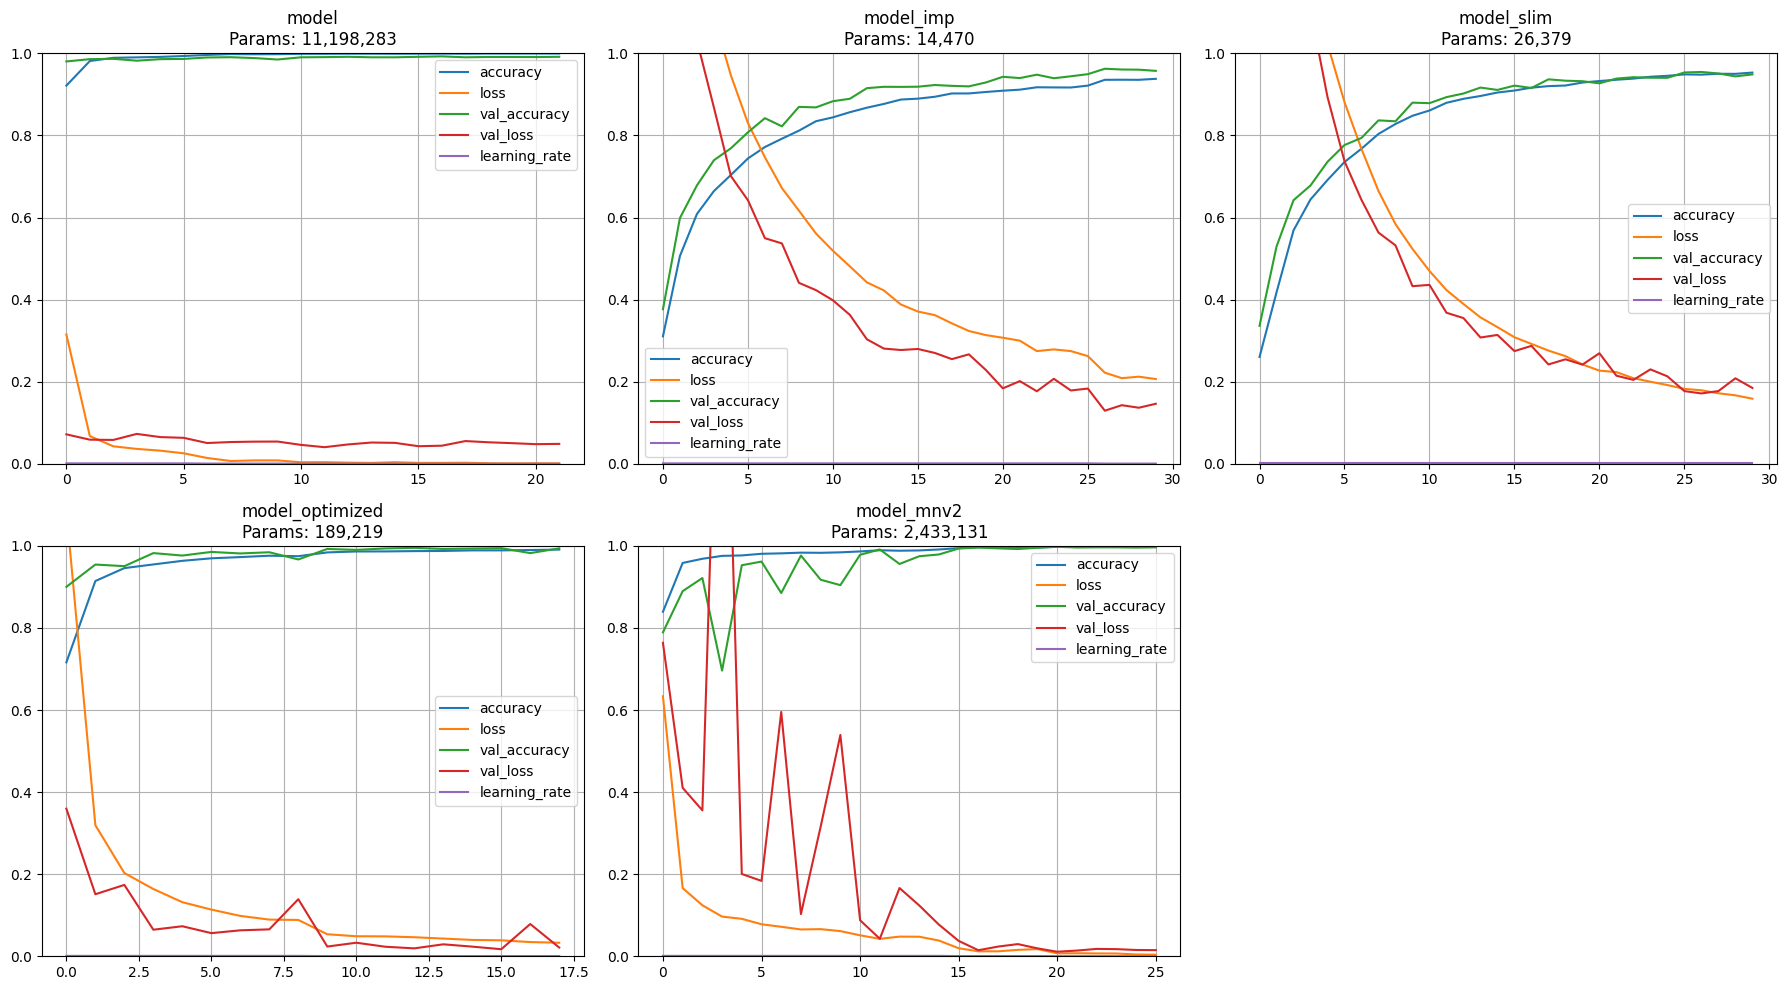

In [15]:
# Configura la griglia in base al numero di modelli
n_models = len(models_info)
n_cols = 3
n_rows = (n_models + n_cols - 1) // n_cols

fig, axs = plt.subplots(n_rows, n_cols, figsize=(6 * n_cols, 5 * n_rows))

# Garantisci che axs sia 2D anche se c'è solo una riga
axs = axs if n_rows > 1 else [axs]

for i, (model_name, info) in enumerate(models_info.items()):
    row = i // n_cols
    col = i % n_cols

    history = info['history']
    model = info['model']

    if history is not None:
        ax = axs[row][col]
        pd.DataFrame(history).plot(ax=ax)
        ax.set_title(f"{model_name}\nParams: {model.count_params():,}")
        ax.grid(True)
        ax.set_ylim(0, 1)

# Nasconde gli assi vuoti, se presenti
for j in range(i + 1, n_rows * n_cols):
    row = j // n_cols
    col = j % n_cols
    fig.delaxes(axs[row][col])

plt.tight_layout()
plt.show()


## Loading the test data and running the predictions

In [16]:
imgs = []
labels = []

for label_name in os.listdir(TEST_PATH):
    label_dir = os.path.join(TEST_PATH, label_name)
    if os.path.isdir(label_dir):
        # Cerca immagini dentro la cartella della label
        for img_path in glob.glob(os.path.join(label_dir, '*')):
            imgs.append(img_path)
            labels.append(label_name)

labels = np.array(labels).astype(int)

In [17]:
def get_predictions(model):
    data = []

    for img in imgs:
        image = cv2.imread(img)
        if image is None:
            print(f"Immagine non valida: {img}")
            continue

        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image_pil = Image.fromarray(image)
        resize_image = image_pil.resize((IMG_HEIGHT, IMG_WIDTH))
        data.append(np.array(resize_image))

    X_test = np.array(data, dtype=np.float32)
    X_test = X_test / 255.0  # Normalizzazione

    pred = np.argmax(model.predict(X_test), axis=-1)
    return pred, X_test


## Classification report

In [19]:
# Funzione per ottenere le metriche in formato dict
def get_classification_metrics(model, labels):
    y_pred, _ = get_predictions(model)
    report = classification_report(labels, y_pred, output_dict=True, zero_division=0)
    return report

# Modelli da confrontare
models_to_evaluate = {
    'Original': models_info['model']['model'],
    'Improved': models_info['model_imp']['model'],
    'Slim': models_info['model_slim']['model'],
    'MobileNetV2': models_info['model_optimized']['model'],
    'Optimized': models_info['model_mnv2']['model']
}

# Calcola i report per ogni modello
metrics_data = {}

for name, model in models_to_evaluate.items():
    metrics = get_classification_metrics(model, labels)
    # Salviamo solo le medie ('macro avg' e/o 'weighted avg')
    metrics_data[name] = {
        'Precision': metrics['macro avg']['precision'],
        'Recall': metrics['macro avg']['recall'],
        'F1-score': metrics['macro avg']['f1-score'],
        'Accuracy': metrics['accuracy']  # dal report completo
    }

# Crea un DataFrame
metrics_df = pd.DataFrame(metrics_data)
print(metrics_df.round(3).T)  # Trasposta per avere modelli come righe


74/74 [==============================] - 2s 25ms/step
             Precision  Recall  F1-score  Accuracy
Original         0.993   0.966     0.975     0.994
Improved         0.848   0.805     0.818     0.955
Slim             0.895   0.819     0.840     0.954
MobileNetV2      0.956   0.951     0.952     0.994
Optimized        0.994   0.979     0.985     0.995


In [24]:
print(classification_report(labels, get_predictions(model)[0]))
print(classification_report(labels, get_predictions(model_imp)[0]))
print(classification_report(labels, get_predictions(model_slim)[0]))
print(classification_report(labels, get_predictions(model_mnv2)[0]))
print(classification_report(labels, get_predictions(model_optimized)[0]))

74/74 [==============================] - 2s 26ms/step
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        10
           1       0.99      0.97      0.98       102
           2       1.00      0.99      1.00       139
           3       0.96      1.00      0.98        22
           4       1.00      1.00      1.00        38
           5       0.82      0.88      0.85        16
           7       1.00      1.00      1.00         4
           9       0.99      0.92      0.95       144
          10       0.74      0.97      0.84        35
          11       1.00      0.93      0.97        45
          12       0.81      0.94      0.87        18
          13       0.99      1.00      1.00       327
          14       0.94      0.98      0.96       146
          15       1.00      0.72      0.84        25
          16       1.00      1.00      1.00        37
          17       0.86      0.99      0.92       203
          18       0.95    

/usr/local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/usr/local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/usr/local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


74/74 [==============================] - 2s 32ms/step
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.74      0.72      0.73       102
           2       0.61      0.94      0.74       139
           3       0.33      0.09      0.14        22
           4       0.73      0.50      0.59        38
           5       1.00      0.06      0.12        16
           7       0.00      0.00      0.00         4
           9       0.83      0.72      0.77       144
          10       0.60      0.09      0.15        35
          11       0.45      0.56      0.50        45
          12       0.17      0.89      0.29        18
          13       0.70      0.89      0.78       327
          14       0.48      0.58      0.53       146
          15       0.00      0.00      0.00        25
          16       0.20      0.76      0.32        37
          17       0.62      0.53      0.57       203
          18       0.30    

/usr/local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/usr/local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/usr/local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


74/74 [==============================] - 1s 8ms/step
              precision    recall  f1-score   support

           0       0.50      0.10      0.17        10
           1       0.91      0.60      0.72       102
           2       0.73      0.67      0.70       139
           3       0.80      0.18      0.30        22
           4       0.75      0.71      0.73        38
           5       0.00      0.00      0.00        16
           7       0.00      0.00      0.00         4
           9       0.96      0.53      0.69       144
          10       0.29      0.46      0.36        35
          11       0.16      0.62      0.26        45
          12       0.03      0.17      0.04        18
          13       0.77      0.83      0.80       327
          14       0.18      0.27      0.22       146
          15       1.00      0.12      0.21        25
          16       0.61      0.38      0.47        37
          17       0.23      0.12      0.16       203
          18       0.19     

/usr/local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/usr/local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/usr/local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


74/74 [==============================] - 2s 25ms/step
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        10
           1       0.99      0.97      0.98       102
           2       1.00      0.99      1.00       139
           3       0.96      1.00      0.98        22
           4       1.00      1.00      1.00        38
           5       0.82      0.88      0.85        16
           7       1.00      1.00      1.00         4
           9       0.99      0.92      0.95       144
          10       0.74      0.97      0.84        35
          11       1.00      0.93      0.97        45
          12       0.81      0.94      0.87        18
          13       0.99      1.00      1.00       327
          14       0.94      0.98      0.96       146
          15       1.00      0.72      0.84        25
          16       1.00      1.00      1.00        37
          17       0.86      0.99      0.92       203
          18       0.95    

/usr/local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/usr/local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/usr/local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


74/74 [==============================] - 2s 21ms/step
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        10
           1       0.99      0.97      0.98       102
           2       0.98      1.00      0.99       139
           3       1.00      0.91      0.95        22
           4       1.00      0.95      0.97        38
           5       0.94      0.94      0.94        16
           7       1.00      0.75      0.86         4
           9       1.00      1.00      1.00       144
          10       0.55      0.83      0.66        35
          11       0.96      0.98      0.97        45
          12       0.03      0.28      0.05        18
          13       0.93      0.92      0.93       327
          14       0.84      0.82      0.83       146
          15       0.96      1.00      0.98        25
          16       0.26      0.95      0.41        37
          17       0.65      0.39      0.49       203
          18       0.88    

## Visualizing predictions on Test Data

70/70 [==============================] - 2s 25ms/step


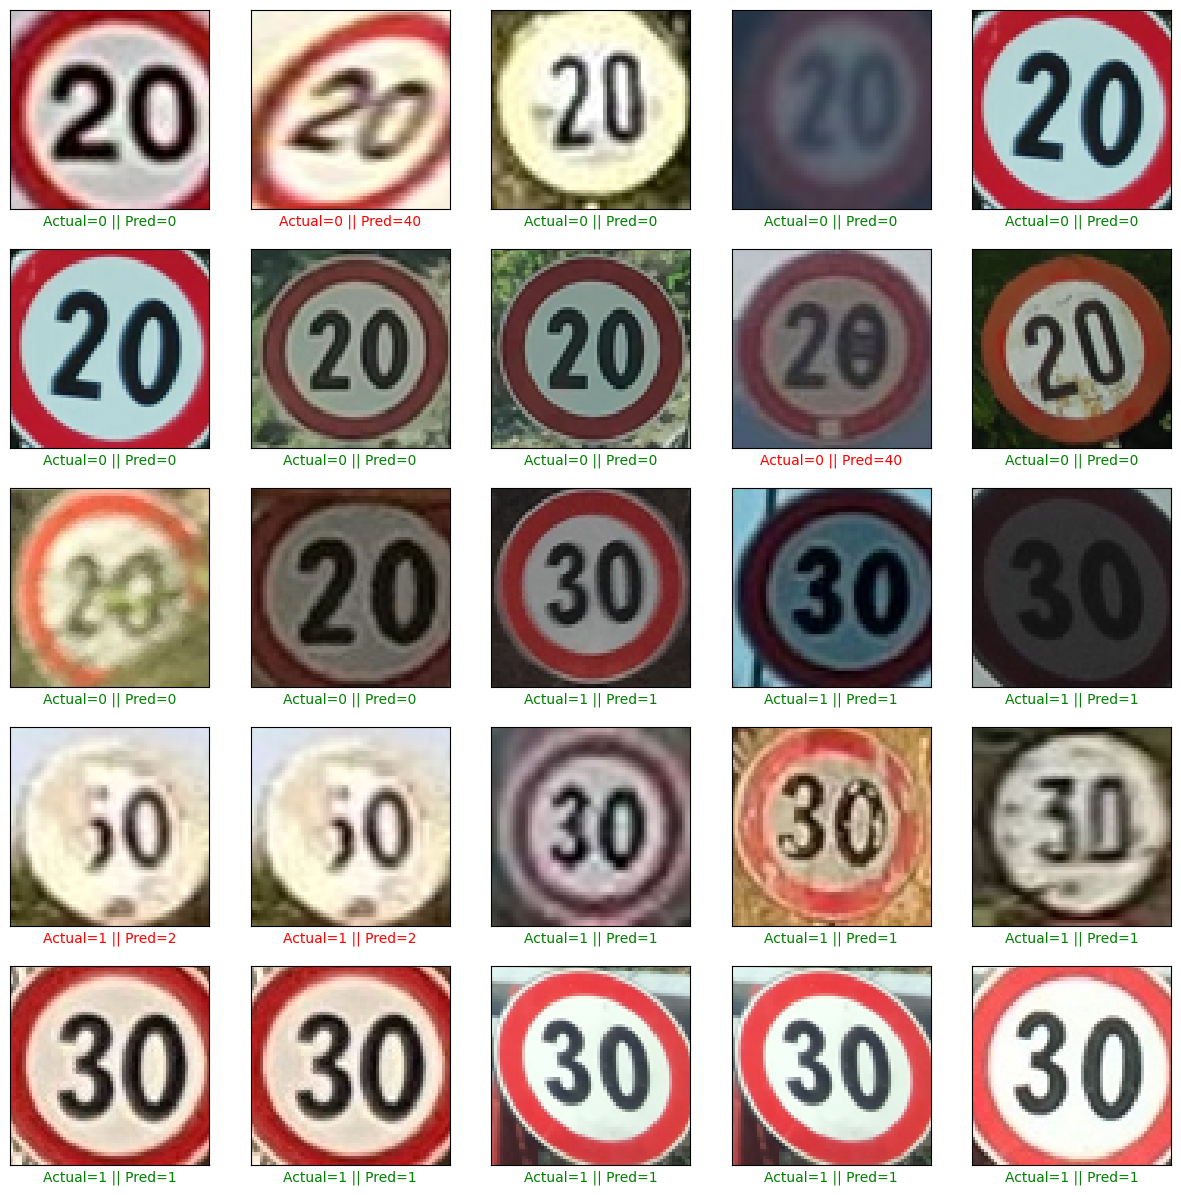

In [37]:
plt.figure(figsize = (15, 15))

pred, X_test = get_predictions(model)

start_index = 0
for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    prediction = pred[start_index + i]
    actual = labels[start_index + i]
    col = 'g'
    if prediction != actual:
        col = 'r'
    plt.xlabel('Actual={} || Pred={}'.format(actual, prediction), color = col)
    plt.imshow(X_test[start_index + i])
plt.show()

# Lime Explainability Evaluation

100%|██████████| 300/300 [00:01<00:00, 170.64it/s]
/tmp/ipykernel_9/2624838571.py:66: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


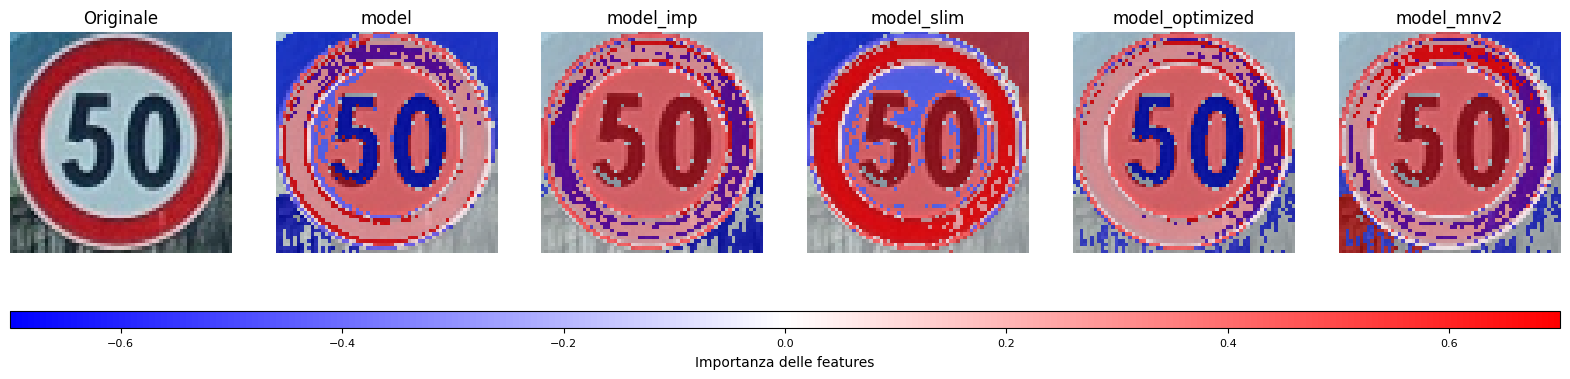

In [26]:
import os
import numpy as np
import cv2
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.colors import Normalize
from lime import lime_image

def predict_fn(images, model):
    batch = np.array([img / 255.0 for img in images])
    return model.predict(batch, verbose=0)

def explain_with_lime(img_array, model):
    explainer = lime_image.LimeImageExplainer(random_state=42)
    return explainer.explain_instance(
        img_array,
        lambda imgs: predict_fn(imgs, model),
        top_labels=1,
        hide_color=1,
        num_samples=300
    )

def generate_overlay(img, explanation, vmin, vmax):
    label = explanation.top_labels[0]
    mask = explanation.get_image_and_mask(
        label,
        positive_only=False,
        num_features=5,
        hide_rest=False
    )[1]

    norm = Normalize(vmin=vmin, vmax=vmax, clip=True)
    heatmap = plt.cm.bwr(norm(mask))[..., :3]

    img_norm = img / 255.0
    return 0.5 * img_norm + 0.5 * heatmap

def show_all_results(img_original, blended_list, model_names, vmin, vmax):
    n_models = len(blended_list)
    fig = plt.figure(figsize=(3 * (n_models + 1) + 2, 4.5))
    gs = fig.add_gridspec(2, n_models + 1, height_ratios=[0.95, 0.05], hspace=0.05)

    # Immagine originale
    ax0 = fig.add_subplot(gs[0, 0])
    ax0.imshow(img_original.astype(np.uint8))
    ax0.set_title("Originale")
    ax0.axis('off')

    # Spiegazioni LIME
    for i, (blended, name) in enumerate(zip(blended_list, model_names)):
        ax = fig.add_subplot(gs[0, i + 1])
        ax.imshow(blended)
        ax.set_title(f"{name}")
        ax.axis('off')

    # Colorbar
    cax = fig.add_subplot(gs[1, :])
    sm = cm.ScalarMappable(norm=Normalize(vmin, vmax), cmap='bwr')
    sm.set_array([])

    cbar = fig.colorbar(sm, cax=cax, orientation='horizontal')
    cbar.set_label('Importanza delle features', labelpad=5)
    cbar.ax.tick_params(labelsize=8)

    plt.tight_layout()
    plt.show()

def execute_lime(img_path):
    # Usa il tuo preprocessing
    img_array = process_image(img_path)
    if img_array is None:
        print(f"Immagine non valida: {img_path}")
        return

    img_array = img_array.astype(np.float64)
    blended_list = []
    model_names = []
    masks = []

    for name, info in models_info.items():
        model = info['model']
        explanation = explain_with_lime(img_array, model)
        label = explanation.top_labels[0]
        mask = explanation.get_image_and_mask(
            label,
            positive_only=False,
            num_features=20,
            hide_rest=False
        )[1]
        masks.append(mask)
        model_names.append(name)

    # Normalizzazione coerente
    all_values = np.concatenate([m.flatten() for m in masks])
    abs_max = max(np.abs(all_values.min()), np.abs(all_values.max()))
    vmin = -abs_max * 0.7
    vmax = abs_max * 0.7

    for mask in masks:
        norm = Normalize(vmin=vmin, vmax=vmax, clip=True)
        heatmap = plt.cm.bwr(norm(mask))[..., :3]
        img_norm = img_array / 255.0
        blended = 0.5 * img_norm + 0.5 * heatmap
        blended_list.append(blended)

    show_all_results(img_array, blended_list, model_names, vmin, vmax)

execute_lime(f'{TEST_PATH}/02/138649562181816_339.jpg')


# Studio disomogeneità geografiche

In [27]:
def geo_label(lat):
    if lat < 41.5594700:
        return 'sud'
    elif lat > 44.801485:
        return 'nord'
    else:
        return 'centre'

def build_paths(df, base_path='./'):
    return [
        os.path.join(base_path, f"{row['feature_index']:02d}", row['filename'])
        for _, row in df.iterrows()
    ]

def get_predictions_from_paths(model, image_paths):
    data = []
    for img_path in image_paths:
        img = process_image(img_path)
        if img is not None:
            data.append(img)
        else:
            data.append(np.zeros((IMG_HEIGHT, IMG_WIDTH, 3), dtype=np.uint8))
    X = np.array(data, dtype=np.float32) / 255.0
    preds = np.argmax(model.predict(X, verbose=0), axis=-1)
    return preds

# Caricamento metadati e assegnazione area geografica
sign_info = pd.read_parquet(f'{DATA_DIR}/metadata.parquet')
sign_info = sign_info.loc[sign_info['split'] == 'test']
sign_info[['lat', 'lon']] = sign_info['coordinates'].str.split(",", expand=True).astype(float)
sign_info['geo_area'] = sign_info['lat'].apply(geo_label)

area_dfs = {
    'nord': sign_info[sign_info['geo_area'] == 'nord'],
    'centre': sign_info[sign_info['geo_area'] == 'centre'],
    'sud': sign_info[sign_info['geo_area'] == 'sud']
}

# Calcolo metriche per modello e area
accuracy_results = []

for model_name, info in models_info.items():
    model = info['model']
    for area_name, df_area in area_dfs.items():
        image_paths = build_paths(df_area, TEST_PATH)
        preds = get_predictions_from_paths(model, image_paths)
        true_labels = df_area['feature_index'].values

        acc = np.mean(preds == true_labels)
        report = classification_report(true_labels, preds, output_dict=True, zero_division=0)
        precision = report['macro avg']['precision']
        recall = report['macro avg']['recall']
        f1 = report['macro avg']['f1-score']

        accuracy_results.append({
            'modello': model_name,
            'area': area_name,
            'accuracy': acc,
            'precision': precision,
            'recall': recall,
            'f1': f1
        })

results_df = pd.DataFrame(accuracy_results)
results_df.pivot(index='modello', columns='area', values='accuracy')

area,centre,nord,sud
modello,,,
model,0.985861,0.991337,0.994924
model_imp,0.431877,0.474010,0.487310
model_mnv2,0.946015,0.931931,0.954315
model_optimized,0.704370,0.773515,0.753807
model_slim,0.320051,0.340347,0.362944


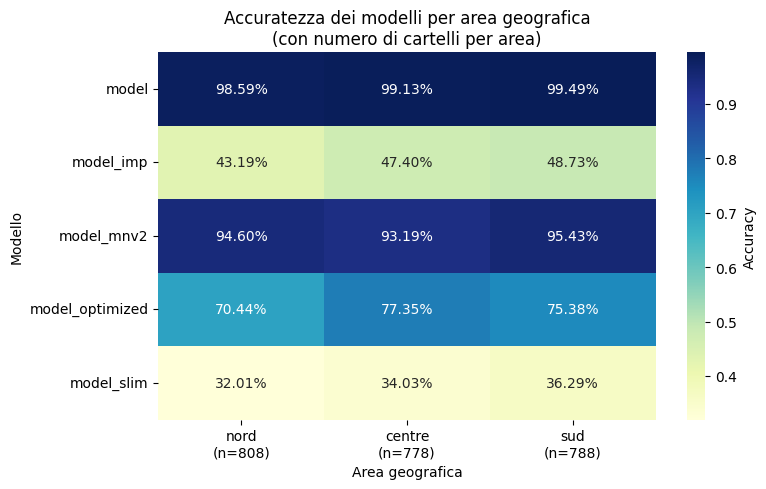

In [28]:
import seaborn as sns
import matplotlib.pyplot as plt

# Calcolo conteggio cartelli per area
area_counts = {area: len(df) for area, df in area_dfs.items()}

# Pivot per heatmap
heatmap_data = results_df.pivot(index='modello', columns='area', values='accuracy')

# Etichette con numero cartelli da usare come annotazioni o titolo
area_labels = [f"{area}\n(n={count})" for area, count in area_counts.items()]
heatmap_data.columns = area_labels  # aggiorna colonne con annotazioni

# Plot della heatmap
plt.figure(figsize=(8, 5))
sns.heatmap(heatmap_data, annot=True, fmt=".2%", cmap="YlGnBu", cbar_kws={'label': 'Accuracy'})
plt.title("Accuratezza dei modelli per area geografica\n(con numero di cartelli per area)")
plt.xlabel("Area geografica")
plt.ylabel("Modello")
plt.tight_layout()
plt.show()
